In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ELU
from keras.layers import Lambda, Dense, Dropout, Flatten
from keras.initializers import RandomUniform
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import ELU
from keras.optimizers import Adam
%matplotlib inline
# np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
# Global Vars
img = (cv.imread('../train/photos/images/gray_Clipped/0.jpg')).shape
img_height = img[0]
img_width = img[1]
img_channels = img[2]
print(img, img_height, img_width, img_channels)

(136, 320, 3) 136 320 3


In [3]:
def adjust_Value(prvs_FRAME, curr_FRAME, HSV_value):
    prvs_FRAME = cv.cvtColor(prvs_FRAME, cv.COLOR_BGR2HSV)
    curr_FRAME = cv.cvtColor(curr_FRAME, cv.COLOR_BGR2HSV)
    prvs_FRAME[...,2] = prvs_FRAME[...,2]*HSV_value
    curr_FRAME[...,2] = curr_FRAME[...,2]*HSV_value
    prvs_FRAME = cv.cvtColor(prvs_FRAME, cv.COLOR_HSV2BGR)
    curr_FRAME = cv.cvtColor(curr_FRAME, cv.COLOR_HSV2BGR)
    return prvs_FRAME, curr_FRAME

In [4]:
def opticalFlow_DENSE(prvs_FRAME, curr_FRAME, dynamic_sat):
    # flow_mat = None
    # image_scale = 0.5
    # pyr_images = 1 # was 3
    # win_size = 15
    # pyr_iterations = 2 # was 3
    # poly_expans = 5
    # std = 1.3 # was 1.2
    
    flow_mat = None
    image_scale = 0.5
    pyr_images = 1 # was 3
    win_size = 15
    pyr_iterations = 2 # was 3
    poly_expans = 5
    std = 1.3 # was 1.2

    hsv = np.zeros_like(prvs_FRAME)
    if dynamic_sat:
        hsv[..., 1] = cv.cvtColor(prvs_FRAME, cv.COLOR_BGR2HSV)[...,1]
    else:
        hsv[...,1] = 255
    prvs_FRAME = cv.cvtColor(prvs_FRAME,cv.COLOR_BGR2GRAY)
    curr_FRAME = cv.cvtColor(curr_FRAME,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs_FRAME,curr_FRAME,flow_mat,image_scale,pyr_images,win_size,pyr_iterations,poly_expans,std,0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
#     hsv = np.asarray(hsv, dtype=np.float32)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    return bgr

In [5]:
def getData(train_meta, kLoopCount, train_index, getSpeed, for_training):
    global img_height, img_width, img_channels
    opt_flows = np.empty((0, img_height, img_width, img_channels), dtype='float32')
    speed = np.empty((0))
    for k in range(kLoopCount):
        HSV_value = np.random.uniform(low=.5, high=1.2)
        #print(train_index)
        curr_FRAME = cv.imread(train_meta['image_path'][train_index])
        prvs_FRAME = cv.imread(train_meta['image_path'][train_index-1])
        if getSpeed:
            speed1 = train_meta['speed'][train_index]
            speed2 = train_meta['speed'][train_index-1]
            speed3 = np.mean((speed1, speed2))
            speed = np.append(speed, speed1)
        if for_training:
            prvs_FRAME, curr_FRAME = adjust_Value(prvs_FRAME, curr_FRAME, HSV_value)
        opt_flow = opticalFlow_DENSE(prvs_FRAME, curr_FRAME, False)
#         opt_flows = np.append(opt_flows, [opt_flow], axis=0)
        opt_flows = np.append(opt_flows, [np.asarray(opt_flow, dtype=np.float32)], axis=0)
    if getSpeed:
        return opt_flows, speed
    else:
        return opt_flows

In [6]:
def getTrainingData(train_meta, train_index, batchSize):
    global img_height, img_width, img_channels
    get_speed = True
    for_training = False
    while True:
        opt_flow_arr = np.empty((0, img_height, img_width, img_channels))
        speed_arr = np.empty((0))
        for i in range(batchSize):
            index = np.random.randint(0, train_index.shape[0])
            opt_flow, speed = getData(train_meta, 1, train_index[index], get_speed, for_training)
            opt_flow_arr = np.append(opt_flow_arr, opt_flow, axis=0)
            speed_arr = np.append(speed_arr, speed)
        #print(opt_flow_arr.shape)
        yield opt_flow_arr, speed_arr

In [7]:
def getValData(train_meta, val_index, batchSize, getSpeed):
    for_training = False
    while True:
        index = 0
        for i in range(len(val_index)):
            if getSpeed:
                opt_flow, speed = getData(train_meta, 1, val_index[index], getSpeed, for_training)
            else:
                opt_flow = getData(train_meta, 1, val_index[index], getSpeed, for_training)
            #opt_flow_arr = np.append(opt_flow_arr, opt_flow)
            index = index + 1
            if getSpeed:
                yield opt_flow, speed
            else:
                yield opt_flow

In [8]:
def createCNNModel():
    global img_height, img_width, img_channels
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=(img_height, img_width, img_channels)))
    #uniform_initializer = RandomUniform(minval=0.00001, maxval=0.0001, seed=None)
    model.add(Conv2D(filters=40, kernel_size=(5,5), strides=(2,2), activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=20, kernel_size=(5,5), strides=(2,2), activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(units=64, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(units=32, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(units=16, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation='elu'))#, kernel_initializer = uniform_initializer, kernel_regularizer=l2(0.001)))
    #opt = Adam(learning_rate=1e-3, epsilon=1e-07)
    model.compile(optimizer='adam', loss='mse')
    
#     model = Sequential()
#     # normalization    
#     # perform custom normalization before lambda layer in network
#     model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = (img_height, img_width, img_channels)))

#     model.add(Conv2D(24, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
    
    
#     model.add(ELU())    
#     model.add(Conv2D(36, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
    
#     model.add(ELU())    
#     model.add(Conv2D(48, (5, 5), 
#                      strides=(2,2), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
#     model.add(ELU())
#     model.add(Dropout(0.5))
#     model.add(Conv2D(64, (3, 3), 
#                      strides = (1,1), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
    
#     model.add(ELU())              
#     model.add(Conv2D(64, (3, 3), 
#                      strides= (1,1), 
#                      padding = 'valid',
#                      kernel_initializer = 'he_normal'))
              
              
#     model.add(Flatten())
#     model.add(ELU())
#     model.add(Dense(100, kernel_initializer = 'he_normal'))
#     model.add(ELU())
#     model.add(Dense(50, kernel_initializer = 'he_normal'))
#     model.add(ELU())
#     model.add(Dense(10, kernel_initializer = 'he_normal'))
#     model.add(ELU())
    
#     # do not put activation at the end because we want to exact output, not a class identifier
#     model.add(Dense(1, kernel_initializer = 'he_normal'))
    
#     # LR was 1e-4 and epsilon was 1e-08
#     adam = Adam(learning_rate=1e-3, epsilon=1e-08)
#     model.compile(optimizer = adam, loss = 'mse')
    
    return model

In [9]:
def a_print_fn(x):
    global train_name
    dic = {'lambd':'L', 'conv2':'C', 'flatt':'F', 'dense':'De', 'dropo':'D'}
    dic2 = {'C':4, 'De':0}
    dic3 = {',':0, ')':1, ' ':0}
    if x[:5] in dic:
        symbol = dic[x[:5]]
        symbol_unit = ''
        index = 13
        commaSpace_count = 0
        if symbol in dic2:
            while True:
                symbol_num = x[index]
                if symbol_num not in dic3:
                    if commaSpace_count == dic2[symbol]:
                        symbol_unit = symbol_unit + symbol_num
                    index = index + 1
                else:
                    if commaSpace_count == dic2[symbol]:
                        break
                    commaSpace_count = commaSpace_count+1
                    index = index + 1
        train_name = train_name + '-' + symbol + symbol_unit
#         print(train_name)
    print(x)

In [10]:
model_name = 'gray_Clipped'
batch_size = 40
epoch_num = 20
steps_per_epoch = 400

train_meta_loc = '../train/text/CSV'
train_meta_loc = os.path.join(train_meta_loc, 'trainGrayClipped_meta.csv')
test_meta_loc = '../test/text/CSV'
test_meta_loc = os.path.join(test_meta_loc, 'testGrayClipped_meta.csv')

asset_path = '../train/assets'
#train_name = f'model={model_name}_C24_C36_C48_D50_C64_C64_De100_De50_De10_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'
#train_name = f'model={model_name}2_elu_C40P_C20P_D25_De128_D30_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'
#train_name = f'model={model_name}_elu_C40_C20_D25_De128_D30_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}__3'
#train_name = f'model={model_name}_elu_C40_C20_D35_De128_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}__4'
#train_name = f'model={model_name}_elu_C40_C20_De128_De64_De15_De1-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}__2'
train_name = f'model={model_name}-elu'
model = createCNNModel()
model.summary(line_length=100, positions=[0.06,0.55,0.67,0.0], print_fn=a_print_fn)
model = 0
train_name_end = f'-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'
train_name = train_name + train_name_end
train_path = os.path.join(asset_path, train_name)

model_train_meta_loc = os.path.join(train_path, 'train_meta.csv')
model_test_meta_loc = os.path.join(train_path, 'test_meta.csv')
test_result_path = os.path.join(train_path, 'test.txt')
history_loc = os.path.join(train_path, 'history.p')
weights_loc = os.path.join(train_path, 'weights.h5')
tensorboard_loc = os.path.join(train_path, train_name)
print(history_loc, '\n', weights_loc, '\n', tensorboard_loc)

Model: "sequential_1"
____________________________________________________________________________________________________
Layer Output Shape                                     Param #     
lambd (None, 136, 320, 3)                              0           
____________________________________________________________________________________________________
conv2 (None, 66, 158, 40)                              3040        
____________________________________________________________________________________________________
conv2 (None, 31, 77, 20)                               20020       
____________________________________________________________________________________________________
flatt (None, 47740)                                    0           
____________________________________________________________________________________________________
dense (None, 128)                                      6110848     
_________________________________________________________________

In [11]:
def start():
    global train_meta_loc, batch_size, epoch_num, steps_per_epoch, train_path
    train_meta = pd.read_csv(train_meta_loc)
    
    data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
    dataset_frames_num = train_meta.shape[0]
    train_frames_num = int(.8*(dataset_frames_num-1))
    val_frames_num = int((dataset_frames_num - train_frames_num))
    print(train_frames_num, val_frames_num)
    
    
    train_index = data_index[:train_frames_num]
    val_index = data_index[train_frames_num:(train_frames_num+val_frames_num)]
    print(train_index.shape, val_index.shape)
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    
    valid_generator = getValData(train_meta, val_index, batch_size, True)
    val_size = len(val_index)
    earlyStopping = EarlyStopping(monitor='val_loss', 
                                  patience=1, 
                                  verbose=1, 
                                  min_delta = 0.23,
                                  mode='min',)
    
    modelCheckpoint = ModelCheckpoint(weights_loc, 
                                      monitor = 'val_loss', 
                                      save_best_only = True, 
                                      mode = 'min', 
                                      verbose = 1,
                                     save_weights_only = True)
    
    tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                                write_graph=True, write_images=True)
    #callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]
    callbacks_list = [modelCheckpoint, tensorboard]
    
    model = createCNNModel()
    
    train_size = len(train_index)
    train_generator = getTrainingData(train_meta, train_index, batch_size)
    history = model.fit_generator(
            train_generator, 
            steps_per_epoch = steps_per_epoch, 
            epochs = epoch_num,
            callbacks = callbacks_list,
            verbose = 1,
            validation_data = valid_generator,
            validation_steps = val_size)

    print(history)
    pickle.dump(history.history, open(history_loc, "wb"))
    
    return model, history.history, valid_generator, val_size

In [12]:
model, history, valid_generator, val_size = start()

16319 4081
(16319,) (4080,)
Epoch 1/20
400/400 [==============================] - 289s 722ms/step - loss: 28.5572 - val_loss: 73.3079

Epoch 00001: val_loss improved from inf to 73.30795, saving model to ../train/assets/model=gray_Clipped-elu-L-C40-C20-F-De128-De64-De32-De16-De1-batch_size=40-num_epoch=20-steps_per_epoch=400/weights.h5
Epoch 2/20
400/400 [==============================] - 281s 701ms/step - loss: 9.2475 - val_loss: 0.0245

Epoch 00002: val_loss improved from 73.30795 to 0.02454, saving model to ../train/assets/model=gray_Clipped-elu-L-C40-C20-F-De128-De64-De32-De16-De1-batch_size=40-num_epoch=20-steps_per_epoch=400/weights.h5
Epoch 3/20
400/400 [==============================] - 281s 703ms/step - loss: 13.1590 - val_loss: 0.4754

Epoch 00003: val_loss did not improve from 0.02454
Epoch 4/20
400/400 [==============================] - 279s 698ms/step - loss: 5.5488 - val_loss: 7.2082

Epoch 00004: val_loss did not improve from 0.02454
Epoch 5/20
400/400 [=================

KeyboardInterrupt: 

In [17]:
#history = pickle.load(open(history_loc, "rb" ))
model = createCNNModel()
model.load_weights(weights_loc)
# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# model.compile(optimizer = adam, loss = 'mse')

In [18]:
train_meta = pd.read_csv(train_meta_loc)

data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
#train_frames_num = int(.8*(dataset_frames_num-1))
train_frames_num = int(.8*(dataset_frames_num-1))
val_frames_num = int(((dataset_frames_num-1) - train_frames_num))
test_frames_num = int(((dataset_frames_num-1) - (train_frames_num + val_frames_num)))
print(train_frames_num, val_frames_num, test_frames_num)

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:(train_frames_num+val_frames_num)]
# test_index = data_index[(train_frames_num+val_frames_num):]
train_generator = getValData(train_meta, train_index, batch_size, True)
valid_generator = getValData(train_meta, val_index, batch_size, True)
# test_generator = getValData(train_meta, test_index, batch_size, True)
train_size = len(train_index)
val_size = len(val_index)
# test_size = len(test_index)

16319 4080 0


In [19]:
train_score = model.evaluate(train_generator, steps=train_size)
print('train score:', train_score)

16319/16319 [==============================] - 174s 11ms/step
train score: 15.162817001342773


In [20]:
val_score = model.evaluate(valid_generator, steps=val_size)
print('val score:', val_score)

4080/4080 [==============================] - 43s 11ms/step
val score: 0.0032233030069619417


In [ ]:
test_score = model.evaluate(test_generator, steps=test_size)
print('test score:', test_score)

In [21]:
print('train score:', train_score)
print('val score:', val_score)
#print('test score:', test_score)

train score: 15.162817001342773
val score: 0.0032233030069619417


In [ ]:
print('train score:', train_score)
print('val score:', val_score)
print('test score:', test_score)

In [23]:
history = pickle.load(open(history_loc, "rb" ))

FileNotFoundError: [Errno 2] No such file or directory: '../train/assets/model=gray_Clipped-elu-L-C40-C20-F-De128-De64-De32-De16-De1-batch_size=40-num_epoch=20-steps_per_epoch=400/history.p'

In [22]:
plt.plot(history['loss'], 'ro')
plt.plot(history['val_loss'], 'go')

NameError: name 'history' is not defined

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
fig_size2 = plt.rcParams["figure.figsize"]
print(fig_size2)

In [ ]:
train_meta = pd.read_csv(train_meta_loc)

data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
train_frames_num = int(.70*(dataset_frames_num-1))

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:]
print(train_index, val_index)
plt.plot(train_meta['speed'][train_index], 'ro')
plt.plot(train_meta['speed'][val_index], 'go')

In [24]:
def predictSpeed(a_meta, a_meta_loc, getSpeed, setError):
    global model_train_meta_loc, model_test_meta_loc, batch_size, weights_loc

    dataset_frames_num = a_meta.shape[0]
    print(dataset_frames_num)
    
    data_index = np.arange(1, (dataset_frames_num))
    data_length = data_index.shape[0]
    print(data_length)
    
    data_gen = getValData(a_meta, data_index, batch_size, getSpeed)
    
    model = createCNNModel()
    model.load_weights(weights_loc)
    
    predicted_speed = model.predict(data_gen, steps=data_length, verbose=1)
    predicted_speed.shape = dataset_frames_num-1
    
    a_meta = a_meta.assign(predicted_speed=pd.Series(np.empty((dataset_frames_num))).values)
    a_meta.loc[:, 'predicted_speed'] = np.nan
    a_meta.loc[1:,'predicted_speed'] = predicted_speed
    
    if setError:
        a_meta = a_meta.assign(error=pd.Series(np.empty((dataset_frames_num))).values)
        a_meta.loc[:, 'error'] = np.nan
        a_meta.loc[1:,'error'] = abs(a_meta.loc[1:, 'speed'] - predicted_speed)

    a_meta.to_csv(a_meta_loc, index=False)

In [25]:
predictSpeed(train_meta, model_train_meta_loc, False, True)

20400
20399
20399/20399 [==============================] - 215s 11ms/step


In [26]:
train_meta = pd.read_csv(model_train_meta_loc)

In [ ]:
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'predicted_speed']))

In [ ]:
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'predicted_speed2']))

In [ ]:
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'predicted_speed3']))

In [59]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(train_meta[:100])

,image_path,image_index,speed,predicted_speed,error,med_prd_spd,mean_prd_spd,med_error,mean_error
0,../train/photos/images/gray_Clipped/0.jpg,0,28.105569,NaN,NaN,NaN,NaN,NaN,NaN
1,../train/photos/images/gray_Clipped/1.jpg,1,28.105569,18.644211,9.461358,18.644211,18.644211,9.461358,9.461358
2,../train/photos/images/gray_Clipped/2.jpg,2,28.106527,18.744402,9.362125,18.744402,18.744402,9.362125,9.362125
3,../train/photos/images/gray_Clipped/3.jpg,3,28.130404,25.699844,2.430560,25.699844,25.699844,2.430560,2.430560
4,../train/photos/images/gray_Clipped/4.jpg,4,28.109243,26.638483,1.470760,26.638483,26.638483,1.470760,1.470760
5,../train/photos/images/gray_Clipped/5.jpg,5,28.088572,25.554605,2.533967,25.554605,25.554605,2.533967,2.533967
6,../train/photos/images/gray_Clipped/6.jpg,6,28.034211,22.103868,5.930343,22.103868,22.103868,5.930343,5.930343
7,../train/photos/images/gray_Clipped/7.jpg,7,28.018491,26.929693,1.088798,26.929693,26.929693,1.088798,1.088798
8,../train/photos/images/gray_Clipped/8.jpg,8,27.986624,24.108843,3.877781,24.108843,24.108843,3.877781,3.877781
9,../train/photos/images/gray_Clipped/9.jpg,9,28.016352,24.826685,3.189667,24.826685,24.826685,3.189667,3.189667


In [ ]:
train_meta = train_meta.loc[:, :'error']

In [ ]:
train_meta.to_csv(model_train_meta_loc, index=False)

In [ ]:
np.mean(train_meta.loc[:,'error'])

In [ ]:
np.mean(train_meta.loc[:,'med_error'])

In [ ]:
np.mean(train_meta.loc[:,'mean_error'])

In [ ]:
print(train_meta.loc[20376:, 'predicted_speed'])

In [28]:
weighted_range = 50 # was 50
#train_meta = train_meta.assign(med_prd_spd=pd.Series(np.empty((20400))).values)
train_meta.loc[:, 'med_prd_spd'] = np.nan
train_meta.loc[1:,'med_prd_spd'] = train_meta[1:]['predicted_speed'].rolling(weighted_range, center=True).median()
train_meta.loc[1:25, 'med_prd_spd'] = train_meta.loc[1:25, 'predicted_speed']
train_meta.loc[20376:, 'med_prd_spd'] = train_meta.loc[20376:, 'predicted_speed']
#train_meta.to_csv(model_train_meta_loc, index=False)

In [30]:
#train_meta = train_meta.assign(med_error=pd.Series(np.empty((20400))).values)
train_meta.loc[:]['med_error'] = np.nan
train_meta.loc[1:,'med_error'] = abs(train_meta.loc[1:, 'speed'] - train_meta.loc[1:,'med_prd_spd'])

In [29]:
weighted_range = 50 # was 50
#train_meta = train_meta.assign(mean_prd_spd=pd.Series(np.empty((20400))).values)
train_meta.loc[:, 'mean_prd_spd'] = np.nan
train_meta.loc[1:,'mean_prd_spd'] = train_meta[1:]['predicted_speed'].rolling(weighted_range, center=True).mean()
train_meta.loc[1:25, 'mean_prd_spd'] = train_meta.loc[1:25, 'predicted_speed']
train_meta.loc[20376:, 'mean_prd_spd'] = train_meta.loc[20376:, 'predicted_speed']
#train_meta.to_csv(model_train_meta_loc, index=False)

In [31]:
#train_meta = train_meta.assign(mean_error=pd.Series(np.empty((20400))).values)
train_meta.loc[:]['mean_error'] = np.nan
train_meta.loc[1:,'mean_error'] = abs(train_meta.loc[1:, 'speed'] - train_meta.loc[1:,'mean_prd_spd'])

In [32]:
train_meta.head()

,image_path,image_index,speed,predicted_speed,error,med_prd_spd,mean_prd_spd,med_error,mean_error
0,../train/photos/images/gray_Clipped/0.jpg,0,28.105569,NaN,NaN,NaN,NaN,NaN,NaN
1,../train/photos/images/gray_Clipped/1.jpg,1,28.105569,18.644211,9.461358,18.644211,18.644211,9.461358,9.461358
2,../train/photos/images/gray_Clipped/2.jpg,2,28.106527,18.744402,9.362125,18.744402,18.744402,9.362125,9.362125
3,../train/photos/images/gray_Clipped/3.jpg,3,28.130404,25.699844,2.430560,25.699844,25.699844,2.430560,2.430560
4,../train/photos/images/gray_Clipped/4.jpg,4,28.109243,26.638483,1.470760,26.638483,26.638483,1.470760,1.470760


In [33]:
train_meta.to_csv(model_train_meta_loc, index=False)

In [34]:
print(np.mean(train_meta.loc[:,'error']))
print(np.mean(train_meta.loc[:,'med_error']))
print(np.mean(train_meta.loc[:,'mean_error']))
print()
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'predicted_speed']))
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'med_prd_spd']))
print(mean_squared_error(train_meta.loc[1:, 'speed'], train_meta.loc[1:, 'mean_prd_spd']))

1.5661528456518807
0.9325731618612202
1.0153303849462894

6.383371163285608
1.7809761899826757
2.088422376078993


In [35]:
data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
#train_frames_num = int(.8*(dataset_frames_num-1))
train_frames_num = int(.6*(dataset_frames_num-1))
val_frames_num = int(.5*((dataset_frames_num-1) - train_frames_num))
test_frames_num = int(((dataset_frames_num-1) - (train_frames_num + val_frames_num)))
print(train_frames_num, val_frames_num, test_frames_num, train_frames_num+val_frames_num+test_frames_num)

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:(train_frames_num+val_frames_num)]
test_index = data_index[(train_frames_num+val_frames_num):]

12239 4080 4080 20399


In [36]:
test1 = 0
test2 = 0
test3 = 0
for i in train_index:
    test1 = test1 + train_meta.loc[i, 'error']
test1_loss = test1/train_frames_num
for i in val_index:
    test2 = test2 + train_meta.loc[i, 'error']
test2_loss = test2/val_frames_num
for i in test_index:
    test3 = test3 + train_meta.loc[i, 'error']
test3_loss = test3/test_frames_num

In [37]:
print(test1_loss, test2_loss, test3_loss)

1.5156917737591178 1.5615379974089874 1.7221385416632675


In [38]:
test_meta = pd.read_csv(test_meta_loc)

In [39]:
predictSpeed(test_meta, model_test_meta_loc, False, False)

10798
10797
10797/10797 [==============================] - 120s 11ms/step


In [40]:
test_meta = pd.read_csv(model_test_meta_loc)

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(test_meta[1080:1640])

,image_path,image_index,speed,predicted_speed,med_prd_spd,mean_prd_spd
1080,../test/photos/images/gray_Clipped/1080.jpg,1080,NaN,20.895006,6.360187,7.385254
1081,../test/photos/images/gray_Clipped/1081.jpg,1081,NaN,2.956303,6.182617,7.159095
1082,../test/photos/images/gray_Clipped/1082.jpg,1082,NaN,2.483277,6.077511,7.111031
1083,../test/photos/images/gray_Clipped/1083.jpg,1083,NaN,0.078462,5.895844,6.896982
1084,../test/photos/images/gray_Clipped/1084.jpg,1084,NaN,21.435041,5.727089,6.846475
1085,../test/photos/images/gray_Clipped/1085.jpg,1085,NaN,22.676523,5.662417,6.737169
1086,../test/photos/images/gray_Clipped/1086.jpg,1086,NaN,3.639402,5.662417,6.675857
1087,../test/photos/images/gray_Clipped/1087.jpg,1087,NaN,1.557617,5.727089,6.876203
1088,../test/photos/images/gray_Clipped/1088.jpg,1088,NaN,5.350432,5.727089,6.874644
1089,../test/photos/images/gray_Clipped/1089.jpg,1089,NaN,2.360805,5.662417,6.811434


In [42]:
weighted_range = 50 # was 50
#test_meta = test_meta.assign(med_prd_spd=pd.Series(np.empty((20400))).values)
test_meta.loc[:, 'med_prd_spd'] = np.nan
test_meta.loc[1:,'med_prd_spd'] = test_meta[1:]['predicted_speed'].rolling(weighted_range, center=True).median()
test_meta.loc[1:25, 'med_prd_spd'] = test_meta.loc[1:25, 'predicted_speed']
test_meta.loc[10774:, 'med_prd_spd'] = test_meta.loc[10774:, 'predicted_speed']
#test_meta.to_csv(model_test_meta_loc, index=False)

In [43]:
weighted_range = 50 # was 50
#test_meta = test_meta.assign(mean_prd_spd=pd.Series(np.empty((20400))).values)
test_meta.loc[:, 'mean_prd_spd'] = np.nan
test_meta.loc[1:,'mean_prd_spd'] = test_meta[1:]['predicted_speed'].rolling(weighted_range, center=True).mean()
test_meta.loc[1:25, 'mean_prd_spd'] = test_meta.loc[1:25, 'predicted_speed']
test_meta.loc[10774:, 'mean_prd_spd'] = test_meta.loc[10774:, 'predicted_speed']
#test_meta.to_csv(model_test_meta_loc, index=False)

In [44]:
test_meta.to_csv(model_test_meta_loc, index=False)

In [45]:
stop_length = test_meta.loc[1080:1640].shape[0]

In [46]:
test1 = 0
test2 = 0
test3 = 0
for i in test_meta.loc[1080:1640, 'predicted_speed']:
    test1 = test1 + i
test1_loss = test1/stop_length
for i in test_meta.loc[1080:1640, 'med_prd_spd']:
    test2 = test2 + i
test2_loss = test2/stop_length
for i in test_meta.loc[1080:1640, 'mean_prd_spd']:
    test3 = test3 + i
test3_loss = test3/stop_length

In [47]:
print(test1_loss, test2_loss, test3_loss)

6.6940019465650895 5.276906360173183 6.71121232801447


In [56]:
test_result = test_meta.loc[:, 'med_prd_spd']

In [57]:
type(test_result)

pandas.core.series.Series

In [58]:
test_result.to_csv(test_result_path, index=False)

In [48]:
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
fig_size2 = plt.rcParams["figure.figsize"]
print(fig_size2)

[6.0, 4.0]
[15.0, 10.0]


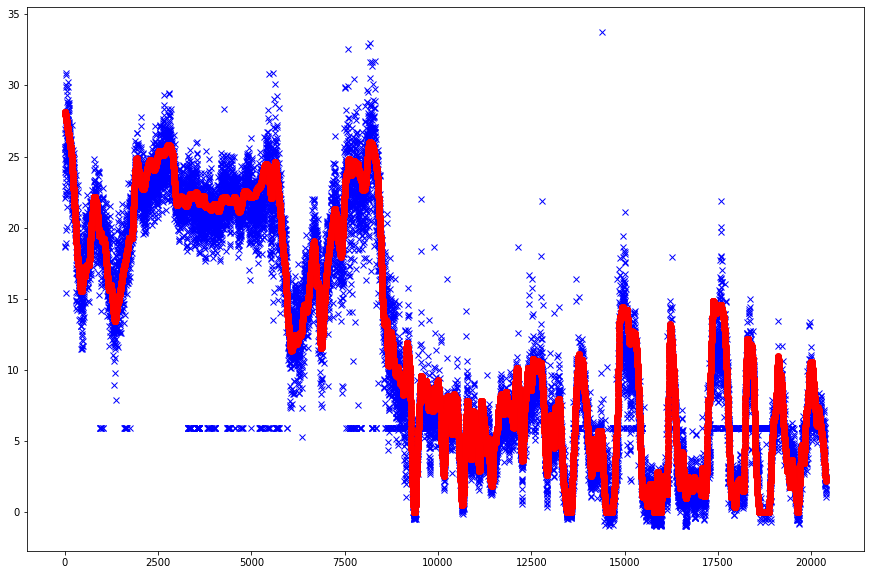

In [49]:
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'predicted_speed'], 'bx')
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'speed'], 'ro')

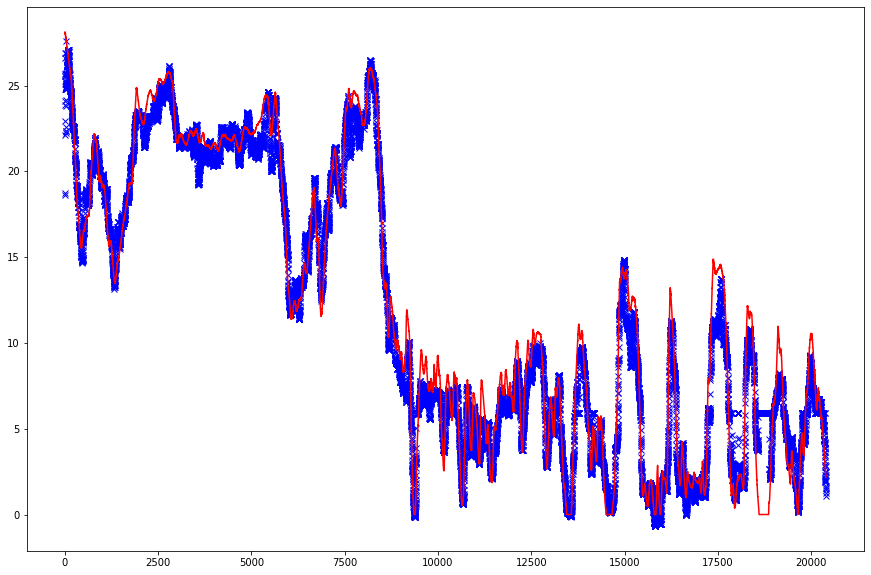

In [50]:
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'med_prd_spd'], 'bx')
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'speed'], 'r')

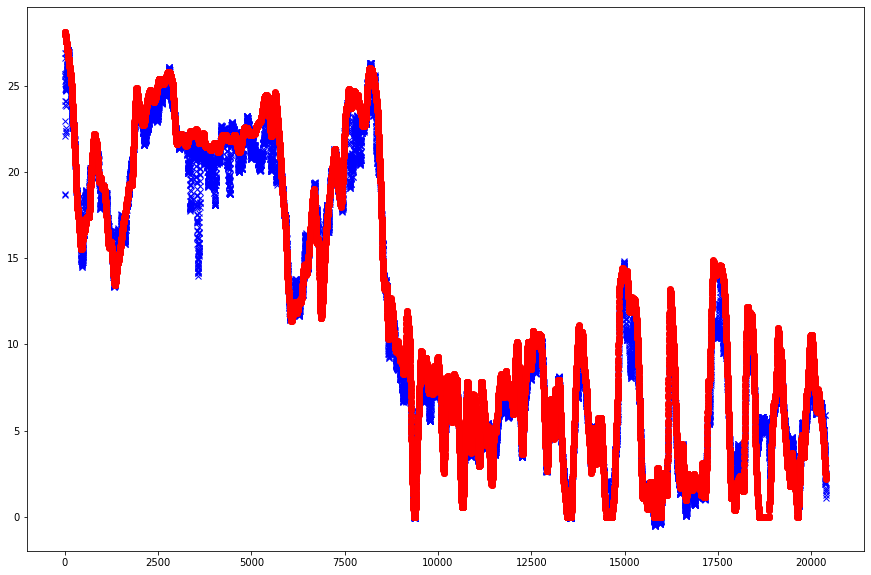

In [51]:
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'mean_prd_spd'], 'bx')
plt.plot(train_meta.loc[1:, 'image_index'], train_meta.loc[1:, 'speed'], 'ro')

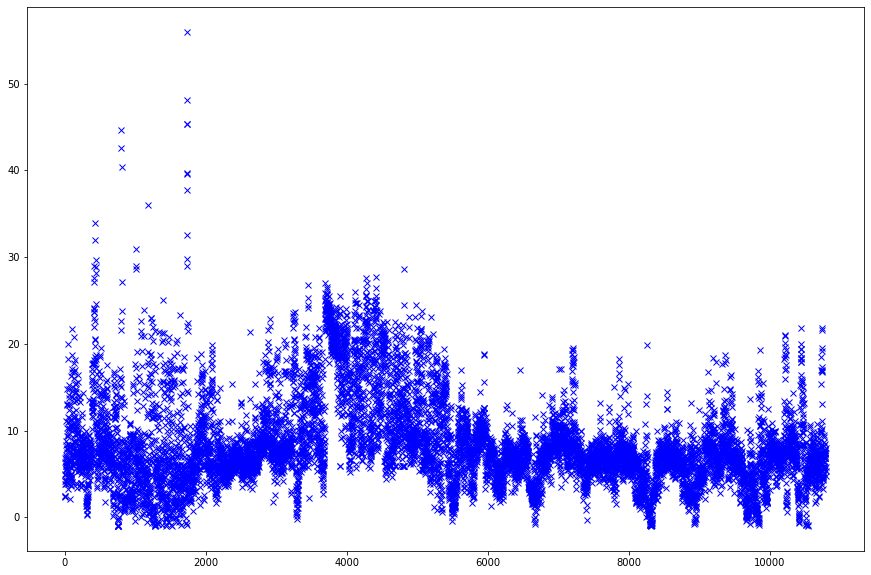

In [52]:
plt.plot(test_meta.loc[1:, 'image_index'], test_meta.loc[1:, 'predicted_speed'], 'bx')

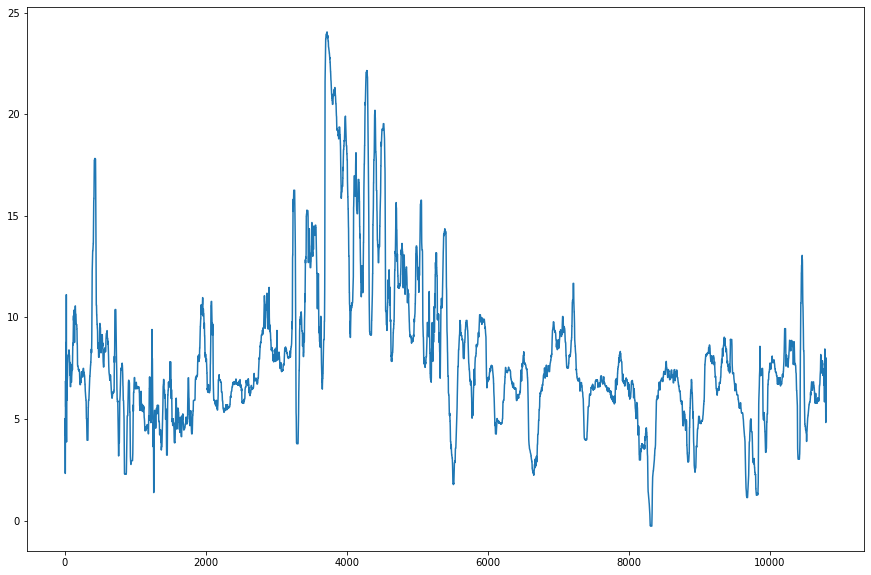

In [53]:
plt.plot(test_meta.loc[1:, 'image_index'], test_meta.loc[1:, 'med_prd_spd'])

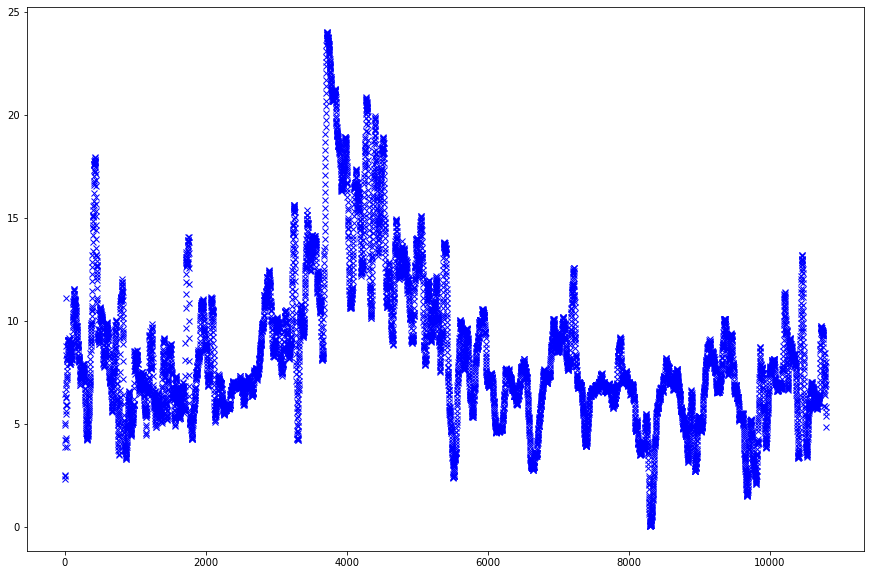

In [54]:
plt.plot(test_meta.loc[1:, 'image_index'], test_meta.loc[1:, 'mean_prd_spd'], 'bx')